## Import Required Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import geopandas as gpd
import rasterio
import os

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## Data Preparation

In [3]:
# Function to extract features from raster files for given samples
def extract_features(samples, raster_path, num_bands=5):
    features = []
    with rasterio.open(raster_path) as src:
        for point in samples.itertuples(index=False):
            spectral_features = []
            for band in range(1, num_bands + 1):
                value = list(src.sample([(point.geometry.x, point.geometry.y)], indexes=band))[0]
                spectral_features.append(value)
            features.append(spectral_features)
    features_array = np.array(features)
    return features_array.reshape(-1, num_bands)

# Load sample points for training, testing, and validation
train_samples = gpd.read_file('Samples_points/training/training_centroids.shp')
test_samples = gpd.read_file('Samples_points/testing/testing_centroids.shp')
val_samples = gpd.read_file('Samples_points/testing/testing_centroids.shp')
val_samples.head()

# Define image path
image_dir = "./Images"
landsat_image_path = os.path.join(image_dir, "Landsat_2021.tif")
val_samples.head()

,ID,ClassID,ClassName,geometry
0,1,1,Antropic,POINT (-55.20718 -7.71981)
1,2,1,Antropic,POINT (-55.85370 -6.68549)
2,3,1,Antropic,POINT (-55.25838 -7.39129)
3,4,1,Antropic,POINT (-56.20916 -7.33093)
4,5,1,Antropic,POINT (-56.30833 -6.52056)


In [4]:

# Extract features for train, test, and validation datasets
train_features_array = extract_features(train_samples, landsat_image_path)
test_features_array = extract_features(test_samples, landsat_image_path)
val_features_array = extract_features(val_samples, landsat_image_path)

In [4]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer

# Sample loading mechanism, assuming you have these variables defined elsewhere
# train_samples, test_samples, val_samples should be predefined data sources like DataFrames
train_labels = train_samples['ClassName']
test_labels = test_samples['ClassName']
val_labels = val_samples['ClassName']

# Assuming train_features_array, test_features_array, val_features_array are also predefined
# They could be loaded similarly to how labels are loaded if not already defined

# Binarize labels
label_binarizer = LabelBinarizer()
# Fit the label binarizer and transform the labels
label_binarizer.fit(np.concatenate([train_labels, test_labels, val_labels]))
y_train = label_binarizer.transform(train_labels)
y_test = label_binarizer.transform(test_labels)
y_val = label_binarizer.transform(val_labels)

# Convert features and labels to NumPy arrays
X_train = np.array(train_features_array, dtype=np.float32)
X_test = np.array(test_features_array, dtype=np.float32)
X_val = np.array(val_features_array, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

In [5]:
X_train = X_train.reshape((-1, 5, 1))  # Add an extra dimension for feature
X_test = X_test.reshape((-1, 5, 1))
X_val = X_val.reshape((-1, 5, 1))

# # Convert labels to one-hot encoding if they are not already
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)
# y_val = tf.keras.utils.to_categorical(y_val, num_classes=5)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
# Optionally, print the classes to verify
print("Classes:", label_binarizer.classes_)

X_train shape: (5000, 5, 1)
y_train shape: (5000, 5)
X_test shape: (5000, 5, 1)
y_test shape: (5000, 5)
X_val shape: (5000, 5, 1)
y_val shape: (5000, 5)
Classes: ['Antropic' 'Deforestation' 'Primary forest' 'Secondary forest' 'Water']


## Model Definition
Here, we define a hybrid model that combines CNN for spatial feature extraction and Transformer for sequence modeling.

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim, **kwargs):
        super(PositionEmbedding, self).__init__(**kwargs)
        self.maxlen = maxlen
        self.embed_dim = embed_dim
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[-2], delta=1)
        positions = self.pos_emb(positions)
        return x + positions

    def get_config(self):
        config = super(PositionEmbedding, self).get_config()
        config.update({
            "maxlen": self.maxlen,
            "embed_dim": self.embed_dim
        })
        return config

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.005, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate
        })
        return config


def create_model(input_shape, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks):
    inputs = layers.Input(shape=input_shape)
    embedding_layer = PositionEmbedding(maxlen=input_shape[0], embed_dim=embed_dim)
    x = embedding_layer(inputs)
    
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Parameters
embed_dim = 32  # Embedding size for each feature
num_heads = 4  # Number of attention heads
ff_dim = 3072  # Hidden layer size in feed forward network inside transformer
num_transformer_blocks = 2  # Number of transformer blocks
input_shape = (5, 1)  # 5 timesteps, 1 feature per timestep
num_classes = 5  # Number of classes

# Initialize model
model = create_model(input_shape, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks)
model.summary()

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


2024-06-11 23:56:58.245347: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 position_embedding (Positio  (None, 5, 32)            160       
 nEmbedding)                                                     
                                                                 
 transformer_block (Transfor  (None, 5, 32)            216640    
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  (None, 5, 32)            216640    
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                      

## Model Training

In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)


Epoch 1/50
157/157 [==============================] - 9s 27ms/step - loss: 1.2397 - accuracy: 0.4614 - val_loss: 1.5204 - val_accuracy: 0.4184
Epoch 2/50
157/157 [==============================] - 3s 21ms/step - loss: 0.9235 - accuracy: 0.6064 - val_loss: 0.7473 - val_accuracy: 0.7034
Epoch 3/50
157/157 [==============================] - 3s 22ms/step - loss: 0.7911 - accuracy: 0.6658 - val_loss: 0.7681 - val_accuracy: 0.6748
Epoch 4/50
157/157 [==============================] - 3s 22ms/step - loss: 0.7509 - accuracy: 0.6936 - val_loss: 0.8550 - val_accuracy: 0.6476
Epoch 5/50
157/157 [==============================] - 3s 21ms/step - loss: 0.7749 - accuracy: 0.6820 - val_loss: 0.8157 - val_accuracy: 0.6366
Epoch 6/50
157/157 [==============================] - 3s 22ms/step - loss: 0.7319 - accuracy: 0.6986 - val_loss: 0.6926 - val_accuracy: 0.7148
Epoch 7/50
157/157 [==============================] - 3s 22ms/step - loss: 0.7410 - accuracy: 0.7004 - val_loss: 0.7163 - val_accuracy: 0.6930

## Evaluation and Visualization

157/157 [==============================] - 1s 8ms/step - loss: 0.6966 - accuracy: 0.7388
Test Loss: 0.6965537667274475
Test Accuracy: 0.7387999892234802


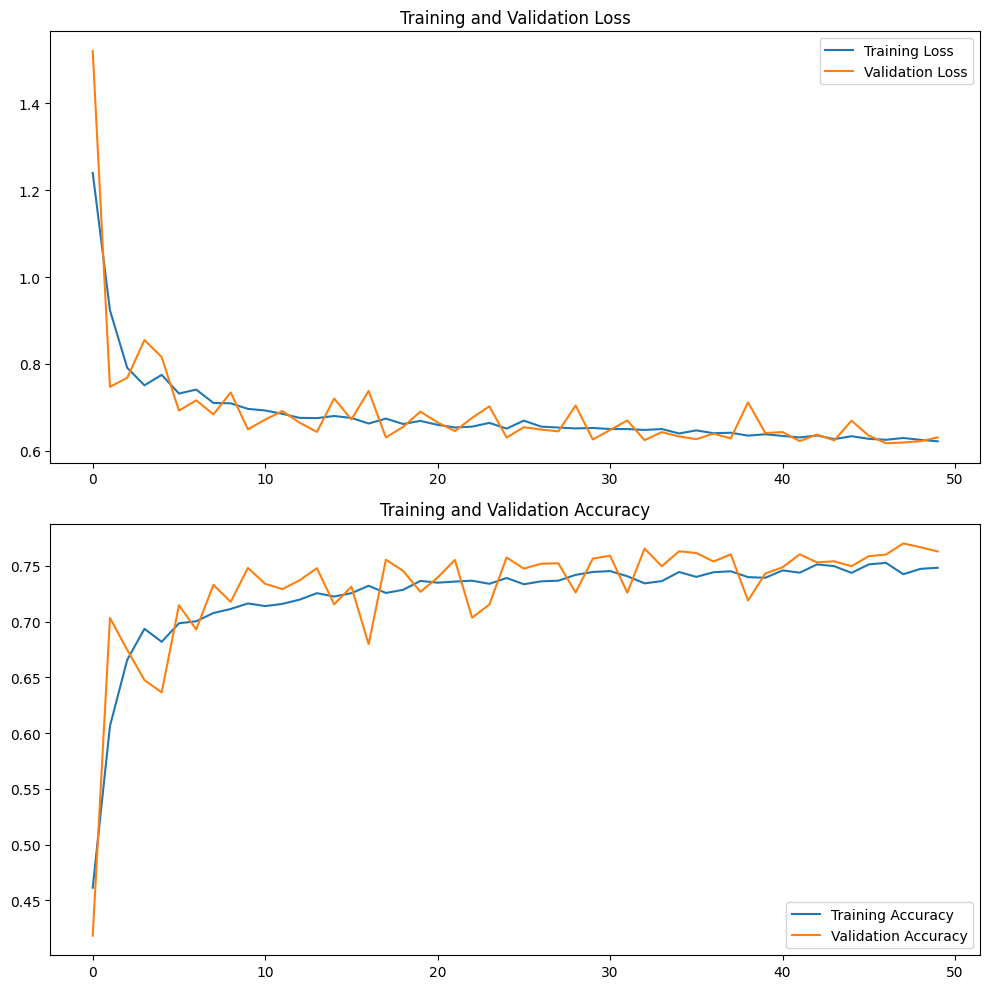

In [8]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    ax[0].plot(history.history['loss'], label='Training Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].legend(loc='best')
    ax[0].set_title('Training and Validation Loss')

    ax[1].plot(history.history['accuracy'], label='Training Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].legend(loc='best')
    ax[1].set_title('Training and Validation Accuracy')

    plt.tight_layout()
    # plt.savefig('Results_models/Hybrid_transfomer/Training&ValidationAccuracy.png')
    plt.show()

plot_training_history(history)


### Saving the Model

In [9]:
model.save("Results_models/ViT_transfomer/ViT_model_model.h5")

### Loading the Model

In [10]:
from tensorflow.keras.models import load_model

model = load_model("Results_models/ViT_transfomer/ViT_model_model.h5", custom_objects={
    "PositionEmbedding": PositionEmbedding,
    "TransformerBlock": TransformerBlock
})
# model.summary()

## Step 3:Model Evaluation 


157/157 [==============================] - 1s 6ms/step


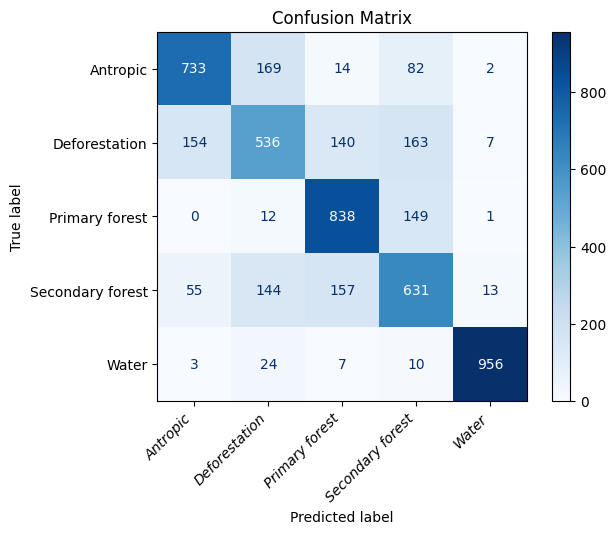

NameError: name 'precision' is not defined

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assume 'model' and 'X_test' are defined, and 'y_test' is available and one-hot encoded
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

# Define class names for the confusion matrix
class_names = ['Antropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])  # Ensure labels are correctly aligned with class names

# Create the confusion matrix display object with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Italicize class names on the x-axis
ax = plt.gca()  # Get the current Axes instance on the current figure
labels = ax.get_xticklabels()  # Get the x-axis tick labels (which are the class names)
plt.setp(labels, rotation=45, horizontalalignment='right', fontstyle='italic')  # Set the properties for the labels
plt.savefig('Results_models/ViT_transfomer/ViT_Confusion_Matrix.png')
plt.show()


# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Save the DataFrame to a CSV file
metrics_df.to_csv('Results_models/ViT_transfomer/ViT_performance_metrics.csv', index=True)
print("Metrics table saved to 'ViT_performance_metrics.csv'.")

# Print the complete metrics table including totals and recall
metrics_df


157/157 [==============================] - 1s 7ms/step


/tmp/ipykernel_52499/4156497591.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(recall_row)


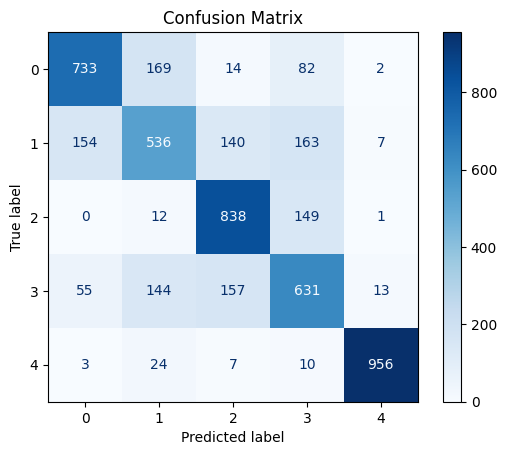

Precision: 0.74
Recall: 0.74
F1-score: 0.74
IoU (Jaccard Score): 0.60


,0,1,2,3,4,Total,Precision (user)
0,733.0,169.0,14.0,82.0,2.0,1000.0,77.57
1,154.0,536.0,140.0,163.0,7.0,1000.0,60.56
2,0.0,12.0,838.0,149.0,1.0,1000.0,72.49
3,55.0,144.0,157.0,631.0,13.0,1000.0,60.97
4,3.0,24.0,7.0,10.0,956.0,1000.0,97.65
Total,945.0,885.0,1156.0,1035.0,979.0,5000.0,
Recall (producer),73.3,53.6,83.8,63.1,95.6,,
Overall Accuracy,,,,,,,73.88


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names = ['0', '1', '2', '3','4']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column

# Append a total predictions row and recall row
metrics_df.loc['Total'] = metrics_df.sum(axis=0)
metrics_df.loc['Total', 'Precision (user)'] = ''  # Set to empty for clarity

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = metrics_df.append(recall_row)

# Add overall accuracy to the DataFrame
metrics_df.loc['Overall Accuracy'] = ['', '', '', '', '', '', overall_accuracy]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df

# Save the DataFrame to a CSV file
# metrics_df.to_csv('Results_models/ViT_transfomer/model_performance_metrics_1.csv', index=True)

# print("Metrics table saved to 'model_performance_metrics.csv'.")


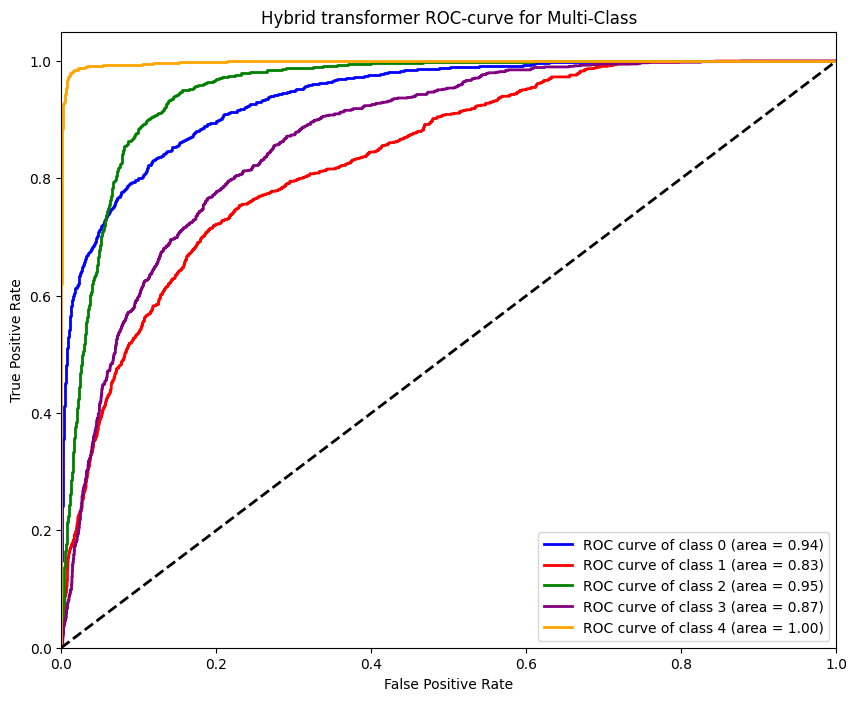

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid transformer ROC-curve for Multi-Class')
plt.legend(loc="lower right")
plt.savefig('Results_models/ViT_transfomer/ViT_ROC_curves_1.png')
plt.show()


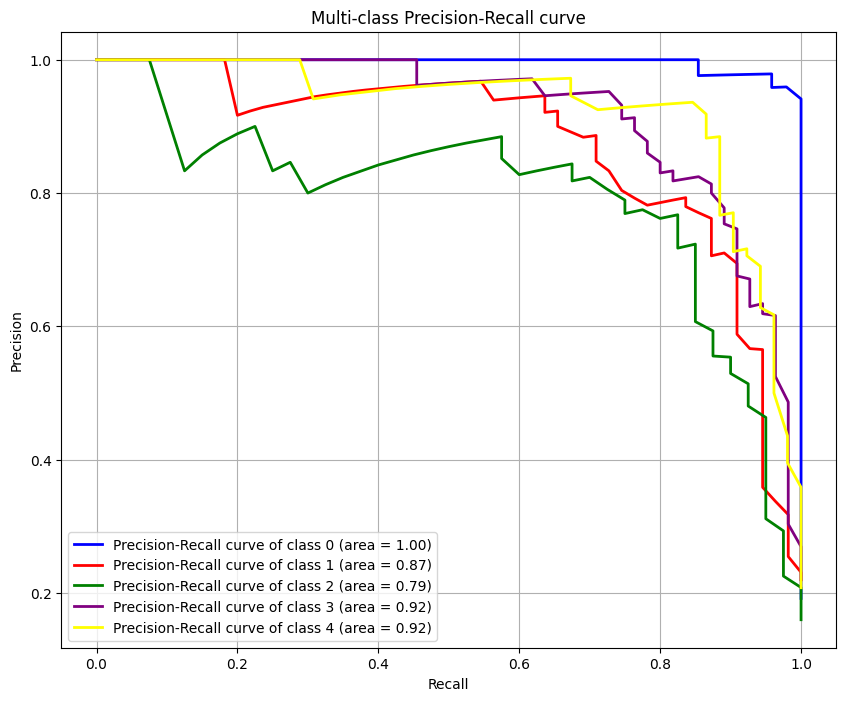

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Generate a synthetic multi-class classification dataset
X, y = make_classification(n_samples=1000, n_features=20,
                           n_classes=5, random_state=42, n_informative=3,
                           n_clusters_per_class=1)

# Binarize the labels for a multi-class setup
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a model using OneVsRestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train, y_train)

# Predict probabilities
y_scores = classifier.predict_proba(X_test)

# Setup plot details
colors = ['blue', 'red', 'green', 'purple', 'yellow']
plt.figure(figsize=(10, 8))

# Compute Precision-Recall curve and area for each class
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_scores[:, i])
    average_precision = average_precision_score(y_test[:, i], y_scores[:, i])
    
    plt.plot(recall, precision, color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision))

plt.title('Multi-class Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('Results_models/ViT_transfomer/PR_curve_classes_1.png')
plt.show()


### Model prediction on inference 

In [21]:
import os
import rasterio
import numpy as np
from skimage.transform import resize
# Define the image directory and file names
image_dir = "./Images"
image_path_2021 = os.path.join(image_dir, "Landsat_2021.tif")
# Load the image using rasterio
with rasterio.open(image_path_2021) as src:
    # Read the image data
    image_data = src.read()
    # Perform any necessary preprocessing steps here (e.g., resizing, cropping, normalization)
    # Make sure the image data shape matches the input shape expected by the model
image_data.shape 

(5, 7046, 7206)

In [22]:
import numpy as np

# Assuming image_data is your image data with shape (5, 7046, 7206)
image_data_reshaped = image_data.reshape(-1, 5, 1)

# Verify the shape
print("Reshaped image data shape:", image_data_reshaped.shape)

Reshaped image data shape: (50773476, 5, 1)


In [23]:
flat_predicted = load_model.predict(image_data_reshaped, batch_size=32)
flat_predicted.shape

AttributeError: 'function' object has no attribute 'predict'

## Transfomer for satelite image time series for image classification of three time steps 

## Import Required Libraries

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import geopandas as gpd
import rasterio
import os
from sklearn.preprocessing import LabelBinarizer
# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## Data Preparation

In [7]:
import os
import rasterio
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

# Define the image directory and file names
image_dir = "./Images"
years_of_interest = [2017, 2019, 2021]

# Load sample points for training, testing, and validation
train_samples = gpd.read_file('Samples_points/training/training_centroids.shp')
test_samples = gpd.read_file('Samples_points/testing/testing_centroids.shp')
val_samples = gpd.read_file('Samples_points/testing/testing_centroids.shp')
len(val_samples)

5000

In [ ]:
# Define the image directory and a pattern for the file names
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

def extract_features(samples, image_paths):
    features = []
    images = [rasterio.open(image_path) for image_path in image_paths]
    for point in samples.itertuples(index=False):
        point_features = []
        for src in images:
            spectral_features = []
            for band_index in range(1, 6):  # Assuming band order starts at 1
                raster_value = list(src.sample([(point.geometry.x, point.geometry.y)], indexes=band_index))[0][0]
                spectral_features.append(raster_value)
            point_features.append(spectral_features)
        features.append(point_features)
    return np.array(features)

In [ ]:
# Extract features for each dataset
train_features_array = extract_features(train_samples, image_paths)
test_features_array = extract_features(test_samples, image_paths)
val_features_array = extract_features(val_samples, image_paths)

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer

# Sample loading mechanism, assuming you have these variables defined elsewhere
# train_samples, test_samples, val_samples should be predefined data sources like DataFrames
train_labels = train_samples['ClassName']
test_labels = test_samples['ClassName']
val_labels = val_samples['ClassName']

# Assuming train_features_array, test_features_array, val_features_array are also predefined
# They could be loaded similarly to how labels are loaded if not already defined

# Binarize labels
label_binarizer = LabelBinarizer()
# Fit the label binarizer and transform the labels
label_binarizer.fit(np.concatenate([train_labels, test_labels, val_labels]))
y_train = label_binarizer.transform(train_labels)
y_test = label_binarizer.transform(test_labels)
y_val = label_binarizer.transform(val_labels)

# Convert features and labels to NumPy arrays
X_train = np.array(train_features_array, dtype=np.float32)
X_test = np.array(test_features_array, dtype=np.float32)
X_val = np.array(val_features_array, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

In [ ]:
X_train = X_train.reshape((-1, 5, 3))  # Add an extra dimension for feature
X_test = X_test.reshape((-1, 5, 3))
X_val = X_val.reshape((-1, 5, 3))

# # Convert labels to one-hot encoding if they are not already
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)
# y_val = tf.keras.utils.to_categorical(y_val, num_classes=5)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
# Optionally, print the classes to verify
print("Classes:", label_binarizer.classes_)

X_train shape: (5000, 5, 3)
y_train shape: (5000, 5)
X_test shape: (5000, 5, 3)
y_test shape: (5000, 5)
X_val shape: (5000, 5, 3)
y_val shape: (5000, 5)
Classes: ['Antropic' 'Deforestation' 'Primary forest' 'Secondary forest' 'Water']


## Model Definition
Here, we define a hybrid model that combines CNN for spatial feature extraction and Transformer for sequence modeling.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim, **kwargs):
        super(PositionEmbedding, self).__init__(**kwargs)
        self.maxlen = maxlen
        self.embed_dim = embed_dim
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        positions = tf.expand_dims(positions, axis=0)
        positions = tf.tile(positions, [tf.shape(x)[0], 1, 1])
        return x + positions

    def get_config(self):
        config = super(PositionEmbedding, self).get_config()
        config.update({
            "maxlen": self.maxlen,
            "embed_dim": self.embed_dim
        })
        return config

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate
        })
        return config

def create_model(input_shape, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(embed_dim)(inputs)
    embedding_layer = PositionEmbedding(maxlen=input_shape[0], embed_dim=embed_dim)
    x = embedding_layer(x)
    
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Parameters
embed_dim = 32  # Embedding size for each feature
num_heads = 4  # Number of attention heads
ff_dim = 3072  # Hidden layer size in feed forward network inside transformer
num_transformer_blocks = 2  # Number of transformer blocks
input_shape = (5, 3)  # 5 features, 3 timesteps
num_classes = 5  # Number of classes

# Initialize model
model = create_model(input_shape, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks)
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 3)]            0         
                                                                 
 dense_18 (Dense)            (None, 5, 32)             128       
                                                                 
 position_embedding_3 (Posit  (None, 5, 32)            160       
 ionEmbedding)                                                   
                                                                 
 transformer_block_6 (Transf  (None, 5, 32)            216640    
 ormerBlock)                                                     
                                                                 
 transformer_block_7 (Transf  (None, 5, 32)            216640    
 ormerBlock)                                                     
                                                           

## Model Training

In [ ]:
# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)


Epoch 1/50
157/157 [==============================] - 7s 28ms/step - loss: 0.8652 - accuracy: 0.6632 - val_loss: 0.8064 - val_accuracy: 0.6666
Epoch 2/50
157/157 [==============================] - 4s 23ms/step - loss: 0.6150 - accuracy: 0.7694 - val_loss: 0.7044 - val_accuracy: 0.7370
Epoch 3/50
157/157 [==============================] - 4s 24ms/step - loss: 0.5885 - accuracy: 0.7820 - val_loss: 0.6057 - val_accuracy: 0.7718
Epoch 4/50
157/157 [==============================] - 4s 24ms/step - loss: 0.5743 - accuracy: 0.7916 - val_loss: 0.6056 - val_accuracy: 0.7738
Epoch 5/50
157/157 [==============================] - 4s 24ms/step - loss: 0.5340 - accuracy: 0.8050 - val_loss: 0.5209 - val_accuracy: 0.8192
Epoch 6/50
157/157 [==============================] - 4s 24ms/step - loss: 0.5480 - accuracy: 0.8022 - val_loss: 0.5978 - val_accuracy: 0.7818
Epoch 7/50
157/157 [==============================] - 4s 23ms/step - loss: 0.5471 - accuracy: 0.7964 - val_loss: 0.5111 - val_accuracy: 0.8156

## Evaluation and Visualization

157/157 [==============================] - 1s 8ms/step - loss: 0.5182 - accuracy: 0.8206
Test Loss: 0.5182313323020935
Test Accuracy: 0.8205999732017517


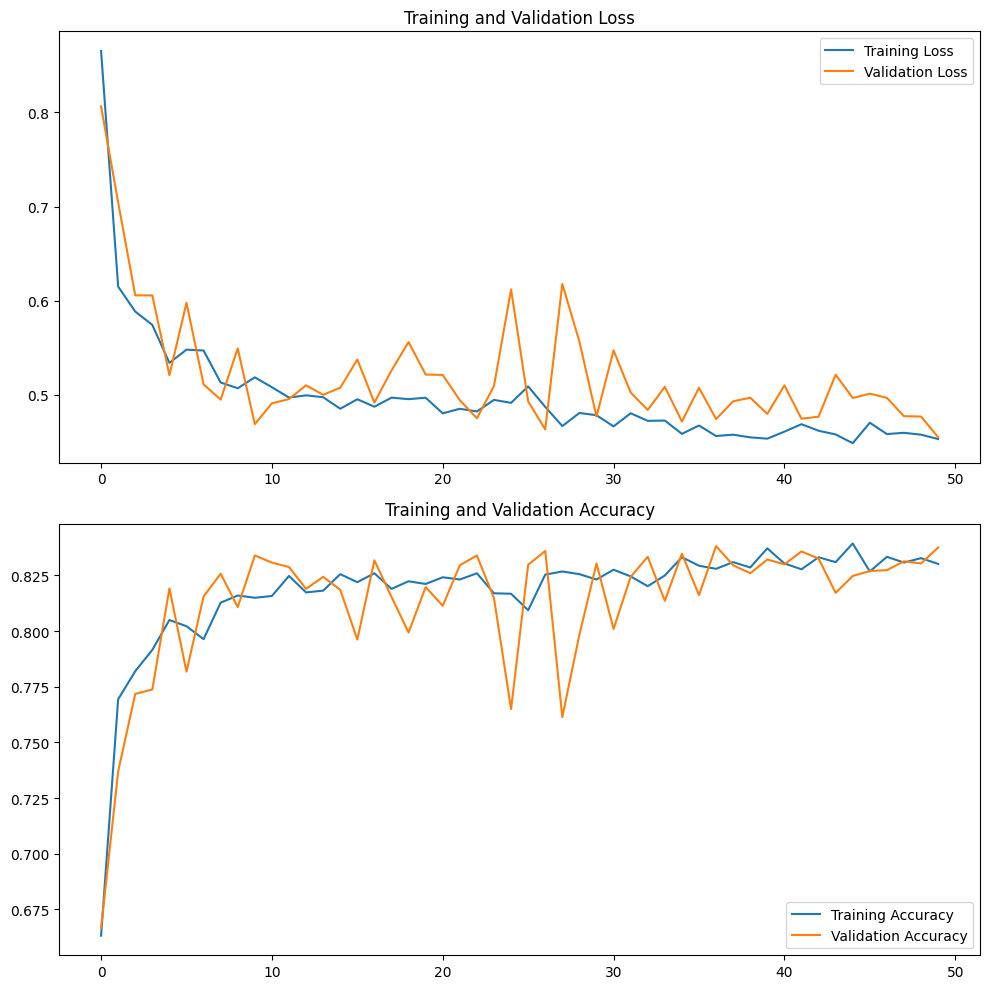

157/157 [==============================] - 2s 7ms/step


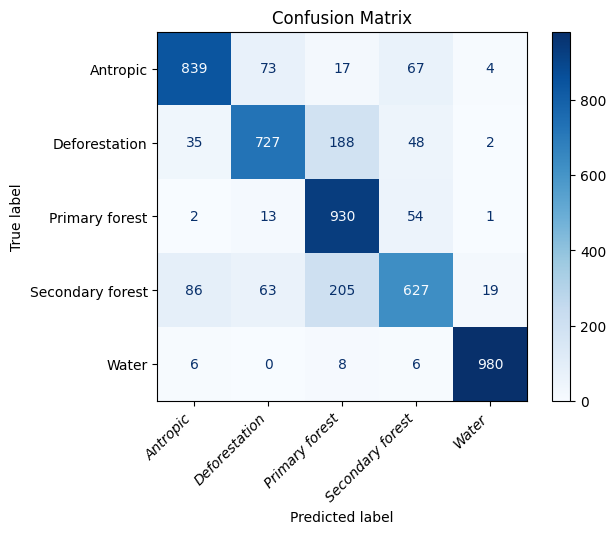

Precision: 0.83
Recall: 0.82
F1-score: 0.82
IoU (Jaccard Score): 0.70


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    ax[0].plot(history.history['loss'], label='Training Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].legend(loc='best')
    ax[0].set_title('Training and Validation Loss')

    ax[1].plot(history.history['accuracy'], label='Training Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].legend(loc='best')
    ax[1].set_title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Confusion matrix and metrics calculation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score
import numpy as np

# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

# Define class names for the confusion matrix
class_names = ['Antropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])  # Ensure labels are correctly aligned with class names

# Create the confusion matrix display object with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Italicize class names on the x-axis
ax = plt.gca()  # Get the current Axes instance on the current figure
labels = ax.get_xticklabels()  # Get the x-axis tick labels (which are the class names)
plt.setp(labels, rotation=45, horizontalalignment='right', fontstyle='italic')  # Set the properties for the labels
plt.savefig('Results_models/ViT_transfomer/ViT_Confusion_Matrix_3.png')
plt.show()

# Calculate precision, recall, f1-score, and IoU
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')


157/157 [==============================] - 1s 7ms/step


/tmp/ipykernel_447/1812967932.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(recall_row)


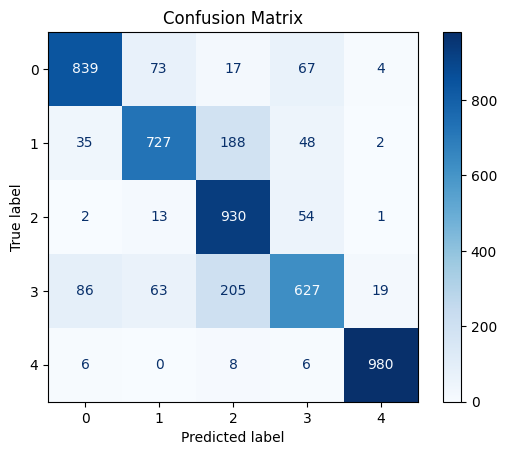

Precision: 0.83
Recall: 0.82
F1-score: 0.82
IoU (Jaccard Score): 0.70


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names = ['0', '1', '2', '3','4']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column

# Append a total predictions row and recall row
metrics_df.loc['Total'] = metrics_df.sum(axis=0)
metrics_df.loc['Total', 'Precision (user)'] = ''  # Set to empty for clarity

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = metrics_df.append(recall_row)

# Add overall accuracy to the DataFrame
metrics_df.loc['Overall Accuracy'] = ['', '', '', '', '', '', overall_accuracy]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df

# Save the DataFrame to a CSV file
metrics_df.to_csv('Results_models/ViT_transfomer/vit_model_performance_metrics_3.csv', index=True)

# print("Metrics table saved to 'model_performance_metrics.csv'.")


### Saving the Model

In [ ]:
model.save("Results_models/ViT_transfomer/ViT_model_model3.h5")

### Loading the Model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("Results_models/ViT_transfomer/ViT_model_model3.h5", custom_objects={
    "PositionEmbedding": PositionEmbedding,
    "TransformerBlock": TransformerBlock
})
# model.summary()

## Step 3:Model Evaluation 


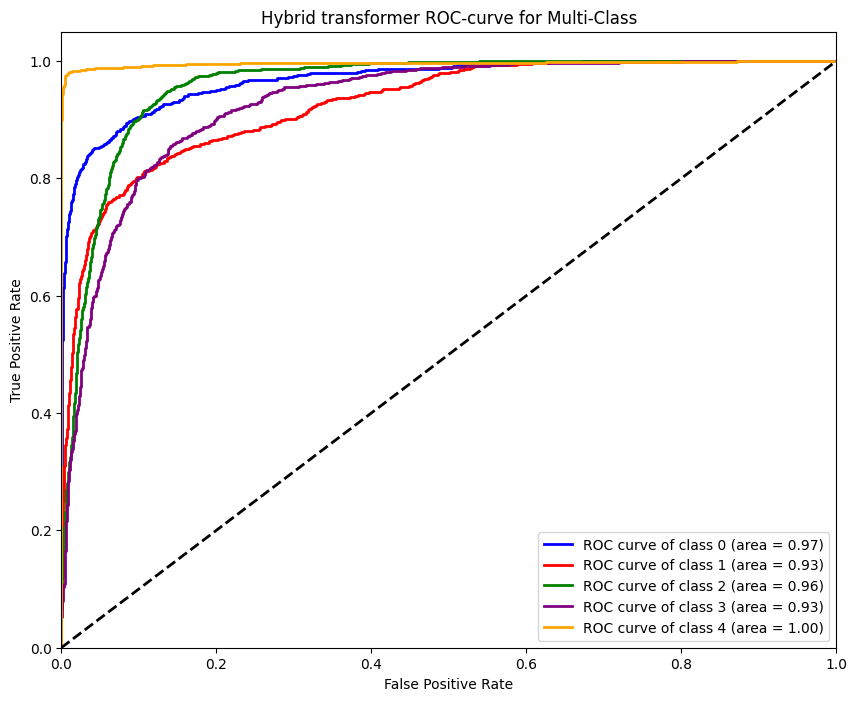

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid transformer ROC-curve for Multi-Class')
plt.legend(loc="lower right")
# plt.savefig('Results_models/ViT_transfome/ViT_ROC_curves.png')
plt.show()

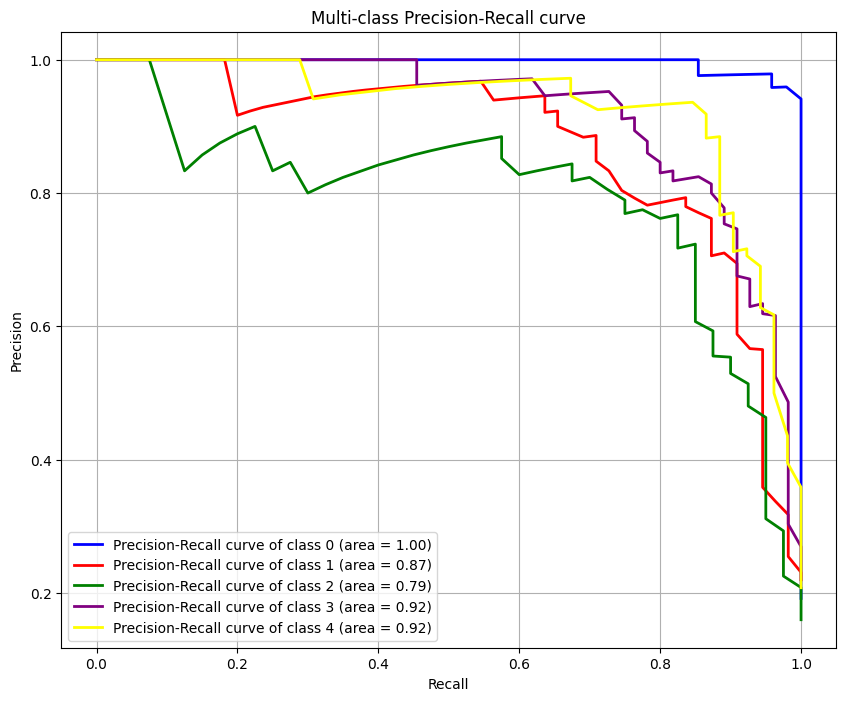

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Generate a synthetic multi-class classification dataset
X, y = make_classification(n_samples=1000, n_features=20,
                           n_classes=5, random_state=42, n_informative=3,
                           n_clusters_per_class=1)

# Binarize the labels for a multi-class setup
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a model using OneVsRestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train, y_train)

# Predict probabilities
y_scores = classifier.predict_proba(X_test)

# Setup plot details
colors = ['blue', 'red', 'green', 'purple', 'yellow']
plt.figure(figsize=(10, 8))

# Compute Precision-Recall curve and area for each class
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_scores[:, i])
    average_precision = average_precision_score(y_test[:, i], y_scores[:, i])
    
    plt.plot(recall, precision, color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision))

plt.title('Multi-class Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
# plt.savefig('PR_curve_classes.png')
plt.show()


### Model prediction on inference 

In [ ]:
import rasterio
import os
import numpy as np
from matplotlib import pyplot as plt

# Define the image directory
image_dir = './Images'

# Define the years of interest
years_of_interest = [2017, 2019, 2021]

# Generate the paths for Landsat images for the specified years
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

# Define the Landsat bands
landsat_bands = [1, 2, 3, 4, 5]  # Band indices for Landsat 5, 8, etc.

# Initialize an empty list to store the stacked images
stacked_images = []

# Process each image
for image_path in image_paths:
    with rasterio.open(image_path) as src:
        # Extract the year from the image path
        year = int(os.path.basename(image_path).split('_')[1].split('.')[0])

        # Stack the bands without normalization
        image = np.stack([src.read(band) for band in landsat_bands], axis=0)

        # Append the raw bands to the list
        stacked_images.append(image)

# Stack the images along the first axis to create a single array
stacked_images_array = np.stack(stacked_images, axis=0)

# Check the shape of the stacked images array
print("Shape of stacked images array:", stacked_images_array.shape)


Shape of stacked images array: (3, 5, 7046, 7206)


In [ ]:
# Transpose the dimensions to bring the last two dimensions together
transposed_array = np.transpose(stacked_images_array, (2, 3, 0, 1))

# Reshape the transposed array
reshaped_array = transposed_array.reshape(-1, transposed_array.shape[2], transposed_array.shape[3])

# Check the shape of the reshaped array
print("Shape of reshaped array:", reshaped_array.shape)

Shape of reshaped array: (50773476, 3, 5)


In [ ]:
# Reshape the array to the desired shape
new_reshaped_array = reshaped_array.reshape(-1,5 , 3)

# Check the shape of the new reshaped array
print("Shape of newly reshaped array:", new_reshaped_array.shape)

Shape of newly reshaped array: (50773476, 5, 3)


In [ ]:
from tensorflow.keras.models import load_model

# Define the path to your model file
model_path = 'Results_models/ViT_transfomer/ViT_model_model3.h5'

# Load the model from the file
model = load_model(model_path, custom_objects={
    'PositionEmbedding': PositionEmbedding,
    'TransformerBlock': TransformerBlock
})

# Assuming 'reshaped_array' is your input data properly shaped for prediction
predictions = model.predict(reshaped_array, batch_size=32)
print(predictions.shape)


ValueError: Failed to find data adapter that can handle input: <class 'ellipsis'>, <class 'NoneType'>

In [ ]:
  import rasterio
import os

# Define the image directory and file names
image_dir = "./Images"
image_path_2021 = os.path.join(image_dir, "Landsat_2021.tif")

# Load the image using rasterio and keep it open
with rasterio.open(image_path_2021) as src:
    # Read the image data
    image_data = src.read()
    
    # Assuming 'classified_image' is your classified map with shape (height, width)
    
    # Reshape the classified image to (height, width)
    classified_image_reshaped = classified_image.reshape(1, *classified_image.shape)
    
    # Save the prediction results
    with rasterio.open("Results_models/ViT_transfomer/Finalcnn_predicted2021_3.tif", 'w', **src.profile) as dst:
        # Write the classified map to the output raster file
        dst.write(classified_image_reshaped[0], 1)
  

## Code for satelite time series of 10 time stesps

## Import Required Libraries

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import geopandas as gpd
import rasterio
import os
from sklearn.preprocessing import LabelBinarizer
# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## Data Preparation

In [9]:
import os
import rasterio
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Define the image directory and file names
image_dir = "./Images"
years_of_interest = [2012, 2013,2014, 2015,2016, 2017,2018, 2019,2020, 2021]

# Load sample points for training, testing, and validation
train_samples = gpd.read_file('Samples_points/training/training_centroids.shp')
test_samples = gpd.read_file('Samples_points/testing/testing_centroids.shp')
val_samples = gpd.read_file('Samples_points/testing/testing_centroids.shp')
val_samples.head()

,ID,ClassID,ClassName,geometry
0,1,1,Antropic,POINT (-55.20718 -7.71981)
1,2,1,Antropic,POINT (-55.85370 -6.68549)
2,3,1,Antropic,POINT (-55.25838 -7.39129)
3,4,1,Antropic,POINT (-56.20916 -7.33093)
4,5,1,Antropic,POINT (-56.30833 -6.52056)


In [10]:
# Define the image directory and a pattern for the file names
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

def extract_features(samples, image_paths):
    features = []
    images = [rasterio.open(image_path) for image_path in image_paths]
    for point in samples.itertuples(index=False):
        point_features = []
        for src in images:
            spectral_features = []
            for band_index in range(1, 6):  # Assuming band order starts at 1
                raster_value = list(src.sample([(point.geometry.x, point.geometry.y)], indexes=band_index))[0][0]
                spectral_features.append(raster_value)
            point_features.append(spectral_features)
        features.append(point_features)
    return np.array(features)

In [11]:
# Extract features for each dataset
train_features_array = extract_features(train_samples, image_paths)
test_features_array = extract_features(test_samples, image_paths)
val_features_array = extract_features(val_samples, image_paths)

In [12]:
# Load class labels for each dataset
train_labels = train_samples['ClassName']
test_labels = test_samples['ClassName']
val_labels = val_samples['ClassName']

# Binarize labels
label_binarizer = LabelBinarizer()
label_binarizer.fit(np.concatenate([train_labels, test_labels, val_labels]))
y_train = label_binarizer.transform(train_labels)
y_test = label_binarizer.transform(test_labels)
y_val = label_binarizer.transform(val_labels)

# Convert features and labels to NumPy arrays
X_train = np.array(train_features_array, dtype=np.float32)
X_test = np.array(test_features_array, dtype=np.float32)
X_val = np.array(val_features_array, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

In [15]:
# Print the shapes of X and y to verify their dimensions
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
# 
# Optionally, print the classes to verify
print("Classes:", label_binarizer.classes_)


X_train shape: (10000, 10, 5)
y_train shape: (10000, 5)
X_test shape: (5000, 10, 5)
y_test shape: (5000, 5)
X_val shape: (5000, 10, 5)
y_val shape: (5000, 5)
Classes: ['Antropic' 'Deforestation' 'Primary forest' 'Secondary forest' 'Water']


In [ ]:
# import numpy as np
# from sklearn.preprocessing import LabelBinarizer

# # Sample loading mechanism, assuming you have these variables defined elsewhere
# # train_samples, test_samples, val_samples should be predefined data sources like DataFrames
# train_labels = train_samples['ClassName']
# test_labels = test_samples['ClassName']
# val_labels = val_samples['ClassName']

# # Assuming train_features_array, test_features_array, val_features_array are also predefined
# # They could be loaded similarly to how labels are loaded if not already defined

# # Binarize labels
# label_binarizer = LabelBinarizer()
# # Fit the label binarizer and transform the labels
# label_binarizer.fit(np.concatenate([train_labels, test_labels, val_labels]))
# y_train = label_binarizer.transform(train_labels)
# y_test = label_binarizer.transform(test_labels)
# y_val = label_binarizer.transform(val_labels)

# # Convert features and labels to NumPy arrays
# X_train = np.array(train_features_array, dtype=np.float32)
# X_test = np.array(test_features_array, dtype=np.float32)
# X_val = np.array(val_features_array, dtype=np.float32)

# y_train = np.array(y_train, dtype=np.float32)
# y_test = np.array(y_test, dtype=np.float32)
# y_val = np.array(y_val, dtype=np.float32)

In [ ]:
# X_train = X_train.reshape((-1, 5, 10))  # Add an extra dimension for feature
# X_test = X_test.reshape((-1, 5, 10))
# X_val = X_val.reshape((-1, 5, 10))

# # # Convert labels to one-hot encoding if they are not already
# # y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
# # y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)
# # y_val = tf.keras.utils.to_categorical(y_val, num_classes=5)
# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)
# print("X_val shape:", X_val.shape)
# print("y_val shape:", y_val.shape)
# # Optionally, print the classes to verify
# print("Classes:", label_binarizer.classes_)

## Model Definition
Here, we define a hybrid model that combines CNN for spatial feature extraction and Transformer for sequence modeling.

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim, **kwargs):
        super(PositionEmbedding, self).__init__(**kwargs)
        self.maxlen = maxlen
        self.embed_dim = embed_dim
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        positions = tf.expand_dims(positions, axis=0)
        positions = tf.tile(positions, [tf.shape(x)[0], 1, 1])
        return x + positions

    def get_config(self):
        config = super(PositionEmbedding, self).get_config()
        config.update({
            "maxlen": self.maxlen,
            "embed_dim": self.embed_dim
        })
        return config

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate
        })
        return config

def create_model(input_shape, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(embed_dim)(inputs)
    embedding_layer = PositionEmbedding(maxlen=input_shape[0], embed_dim=embed_dim)
    x = embedding_layer(x)
    
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Parameters
embed_dim = 32  # Embedding size for each feature
num_heads = 4  # Number of attention heads
ff_dim = 3072  # Hidden layer size in feed forward network inside transformer
num_transformer_blocks = 2  # Number of transformer blocks
input_shape = (5, 10)  # 5 features, 10 timesteps
num_classes = 5  # Number of classes

# Initialize model
model = create_model(input_shape, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks)
model.summary()


TypeError: missing a required argument: 'training'

## Model Training

In [ ]:
# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)


Epoch 1/50
157/157 [==============================] - 9s 31ms/step - loss: 0.8037 - accuracy: 0.6788 - val_loss: 0.6596 - val_accuracy: 0.7472
Epoch 2/50
157/157 [==============================] - 4s 24ms/step - loss: 0.5129 - accuracy: 0.8222 - val_loss: 0.5874 - val_accuracy: 0.8116
Epoch 3/50
157/157 [==============================] - 4s 25ms/step - loss: 0.5017 - accuracy: 0.8194 - val_loss: 0.4296 - val_accuracy: 0.8528
Epoch 4/50
157/157 [==============================] - 4s 25ms/step - loss: 0.4665 - accuracy: 0.8322 - val_loss: 0.4374 - val_accuracy: 0.8556
Epoch 5/50
157/157 [==============================] - 4s 25ms/step - loss: 0.4291 - accuracy: 0.8462 - val_loss: 0.6271 - val_accuracy: 0.7444
Epoch 6/50
157/157 [==============================] - 4s 25ms/step - loss: 0.4412 - accuracy: 0.8422 - val_loss: 0.4375 - val_accuracy: 0.8554
Epoch 7/50
157/157 [==============================] - 4s 24ms/step - loss: 0.4100 - accuracy: 0.8564 - val_loss: 0.4754 - val_accuracy: 0.8200

157/157 [==============================] - 2s 8ms/step


/tmp/ipykernel_458/2045179938.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(recall_row)


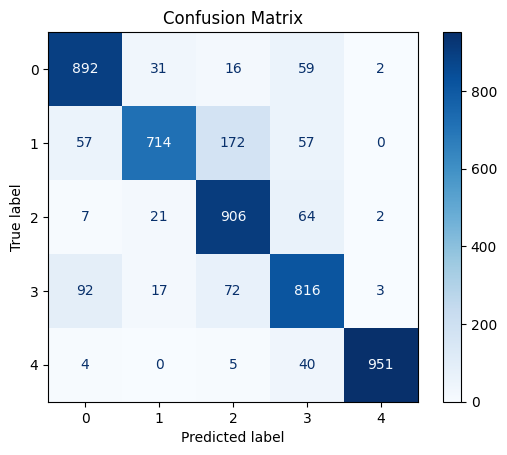

Precision: 0.86
Recall: 0.86
F1-score: 0.86
IoU (Jaccard Score): 0.75


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names = ['0', '1', '2', '3','4']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column

# Append a total predictions row and recall row
metrics_df.loc['Total'] = metrics_df.sum(axis=0)
metrics_df.loc['Total', 'Precision (user)'] = ''  # Set to empty for clarity

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = metrics_df.append(recall_row)

# Add overall accuracy to the DataFrame
metrics_df.loc['Overall Accuracy'] = ['', '', '', '', '', '', overall_accuracy]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df

# Save the DataFrame to a CSV file
metrics_df.to_csv('Results_models/Transformer /st_model_performance_metrics10.csv', index=True)

# print("Metrics table saved to 'model_performance_metrics.csv'.")


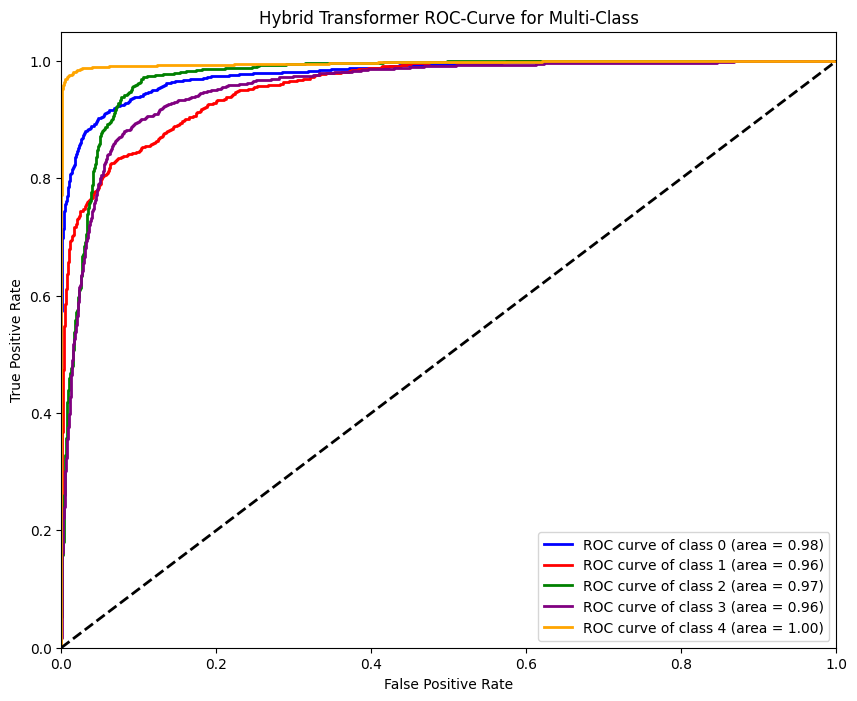

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Transformer ROC-Curve for Multi-Class')
plt.legend(loc="lower right")
plt.savefig('Results_models/Transformer /transformer_ROC_curves.png')
plt.show()


In [ ]:
# Assuming 'X_test' is prepared and 'model' is already trained
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)


157/157 [==============================] - 2s 8ms/step


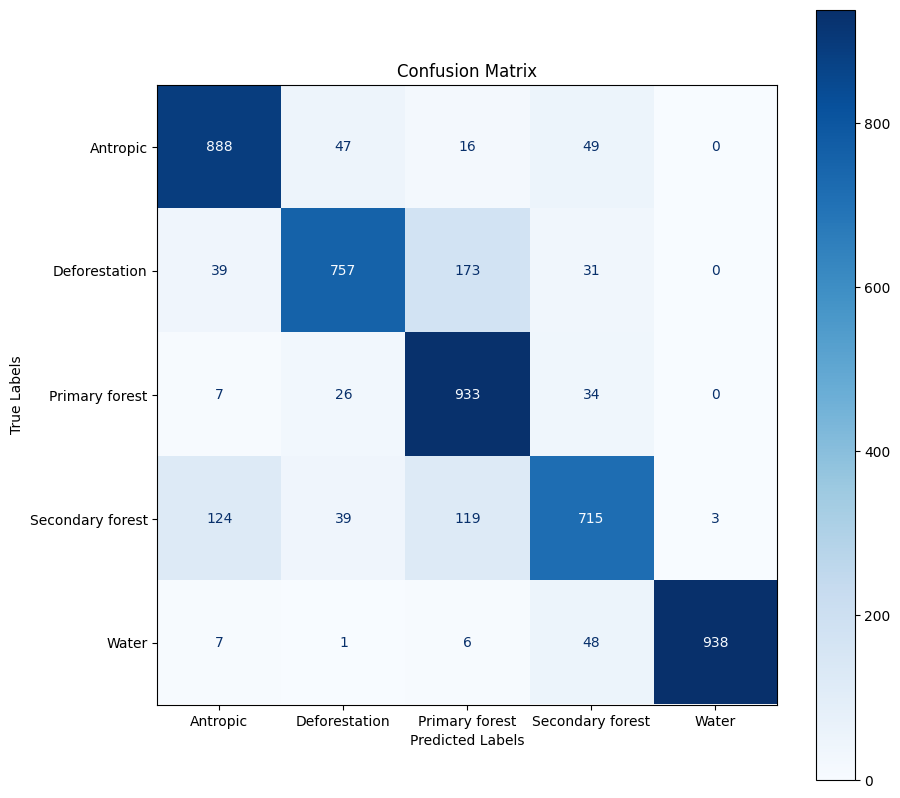

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_binarizer.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# class PositionEmbedding(layers.Layer):
#     def __init__(self, num_channels, time_steps, embed_dim, **kwargs):
#         super(PositionEmbedding, self).__init__(**kwargs)
#         self.num_channels = num_channels
#         self.time_steps = time_steps
#         self.embed_dim = embed_dim
#         self.total_positions = num_channels * time_steps
#         self.pos_emb = layers.Embedding(input_dim=self.total_positions, output_dim=embed_dim)

#     def call(self, x):
#         # Create a position index for each time step
#         positions = tf.range(start=0, limit=self.total_positions, delta=1)
#         positions = self.pos_emb(positions)
#         positions = tf.reshape(positions, (1, self.num_channels, self.time_steps, self.embed_dim))
#         positions = tf.tile(positions, [tf.shape(x)[0], 1, 1, 1])
#         return x + positions

# class TransformerBlock(layers.Layer):
#     def __init__(self, embed_dim, num_heads, ff_dim, rate=0.001, **kwargs):
#         super(TransformerBlock, self).__init__(**kwargs)
#         self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
#         self.ffn = tf.keras.Sequential([
#             layers.Dense(ff_dim, activation="relu"),
#             layers.Dense(embed_dim),
#         ])
#         self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
#         self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
#         self.dropout1 = layers.Dropout(rate)
#         self.dropout2 = layers.Dropout(rate)

#     def call(self, inputs, training=False):
#         # Attention and Feed Forward Network
#         attn_output = self.att(inputs, inputs)
#         attn_output = self.dropout1(attn_output, training=training)
#         out1 = self.layernorm1(inputs + attn_output)
#         ffn_output = self.ffn(out1)
#         ffn_output = self.dropout2(ffn_output, training=training)
#         return self.layernorm2(out1 + ffn_output)

# def create_model(input_shape, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks):
#     inputs = layers.Input(shape=input_shape)
#     # Adjust input to have a feature dimension
#     x = layers.Reshape((input_shape[0], input_shape[1], 1))(inputs)
#     # First, transform features to have a specified embedding dimension
#     x = layers.Dense(embed_dim)(x)
#     # Add positional embeddings
#     embedding_layer = PositionEmbedding(num_channels=input_shape[0], time_steps=input_shape[1], embed_dim=embed_dim)
#     x = embedding_layer(x)
    
#     for _ in range(num_transformer_blocks):
#         x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

#     # Pool over the channel and time dimensions while keeping features
#     x = layers.GlobalAveragePooling2D()(x)
#     outputs = layers.Dense(num_classes, activation="softmax")(x)
#     model = models.Model(inputs=inputs, outputs=outputs)
#     return model

# # Parameters
# embed_dim = 128  # Embedding size for each feature
# num_heads = 4  # Number of attention heads
# ff_dim = 3072  # Hidden layer size in feed forward network inside transformer
# num_transformer_blocks = 2  # Number of transformer blocks
# input_shape = (5, 5)  # 5 channels, 5 time steps
# num_classes = 5  # Number of output classes

# # Initialize model
# model = create_model(input_shape, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks)
# model.summary()


In [ ]:
# # Compile model
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# # Fit the model
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)


## Evaluation and Visualization

157/157 [==============================] - 1s 9ms/step - loss: 0.4429 - accuracy: 0.8558
Test Loss: 0.4428730905056
Test Accuracy: 0.8557999730110168


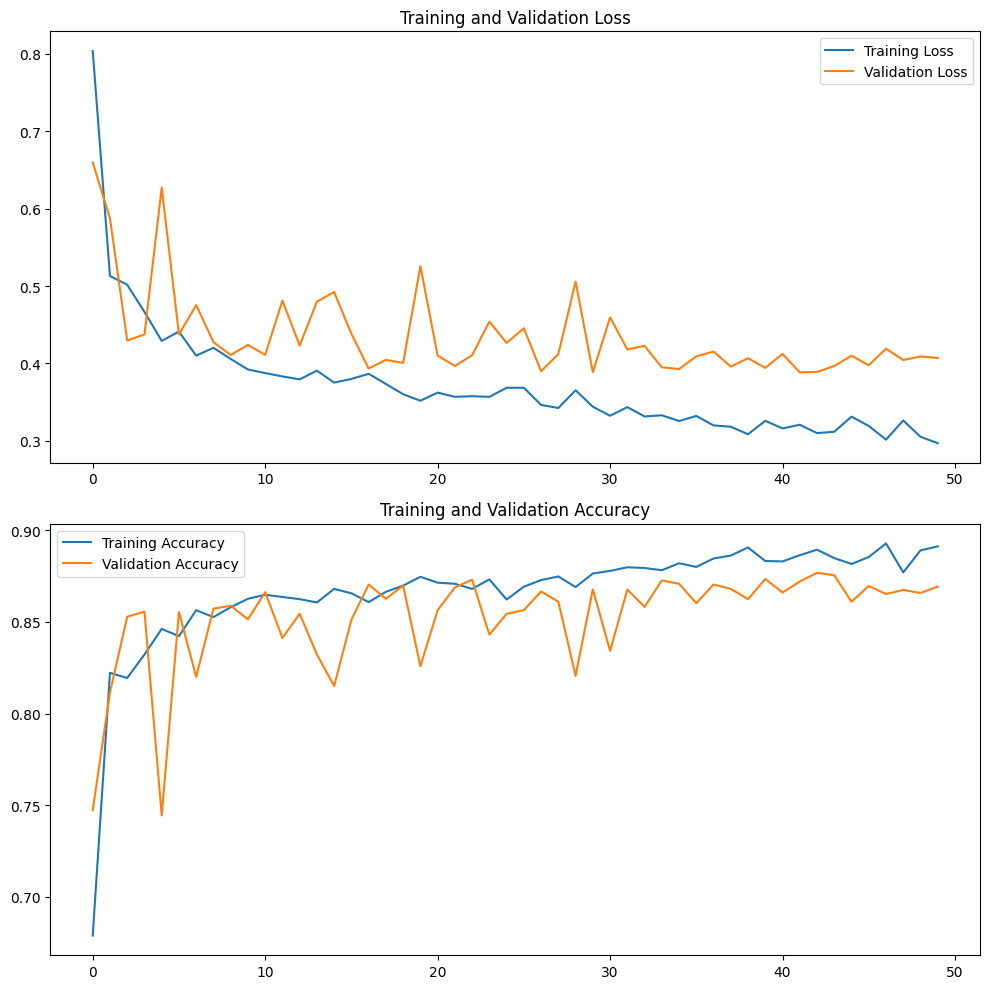

157/157 [==============================] - 1s 8ms/step


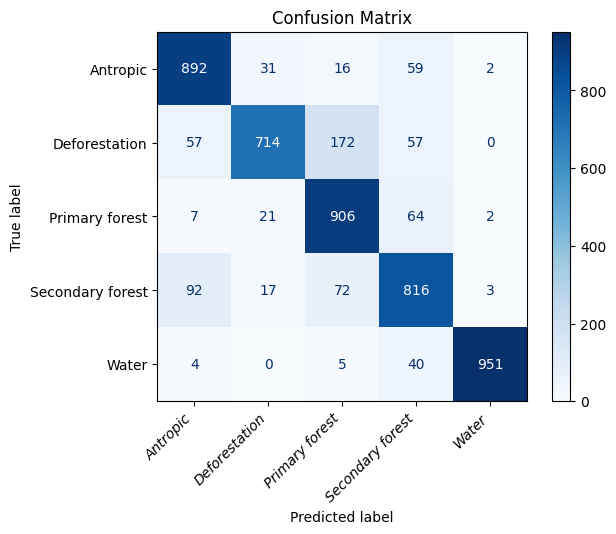

Precision: 0.86
Recall: 0.86
F1-score: 0.86
IoU (Jaccard Score): 0.75


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    ax[0].plot(history.history['loss'], label='Training Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].legend(loc='best')
    ax[0].set_title('Training and Validation Loss')

    ax[1].plot(history.history['accuracy'], label='Training Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].legend(loc='best')
    ax[1].set_title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Confusion matrix and metrics calculation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score
import numpy as np

# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

# Define class names for the confusion matrix
class_names = ['Antropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])  # Ensure labels are correctly aligned with class names

# Create the confusion matrix display object with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Italicize class names on the x-axis
ax = plt.gca()  # Get the current Axes instance on the current figure
labels = ax.get_xticklabels()  # Get the x-axis tick labels (which are the class names)
plt.setp(labels, rotation=45, horizontalalignment='right', fontstyle='italic')  # Set the properties for the labels
plt.savefig('Results_models/ViT_transfomer/ViT_Confusion_Matrix_3.png')
plt.show()

# Calculate precision, recall, f1-score, and IoU
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')


157/157 [==============================] - 1s 8ms/step


/tmp/ipykernel_5388/59276994.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(recall_row)


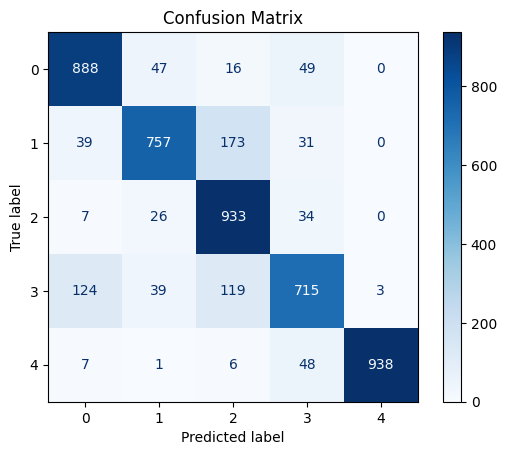

Precision: 0.85
Recall: 0.85
F1-score: 0.85
IoU (Jaccard Score): 0.74


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names = ['0', '1', '2', '3','4']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column

# Append a total predictions row and recall row
metrics_df.loc['Total'] = metrics_df.sum(axis=0)
metrics_df.loc['Total', 'Precision (user)'] = ''  # Set to empty for clarity

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = metrics_df.append(recall_row)

# Add overall accuracy to the DataFrame
metrics_df.loc['Overall Accuracy'] = ['', '', '', '', '', '', overall_accuracy]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df

# Save the DataFrame to a CSV file
metrics_df.to_csv('Results_models/Transformer /st_model_performance_metrics_5.csv', index=True)

# print("Metrics table saved to 'model_performance_metrics.csv'.")


### Saving the Model

In [ ]:
model.save("Results_models/Transformer /Transfomer_model_model10.h5")

### Loading the Model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("Results_models/Transformer /Transfomer_model_model10.h5", custom_objects={
    "PositionEmbedding": PositionEmbedding,
    "TransformerBlock": TransformerBlock
})
# model.summary()

## Step 3:Model Evaluation 


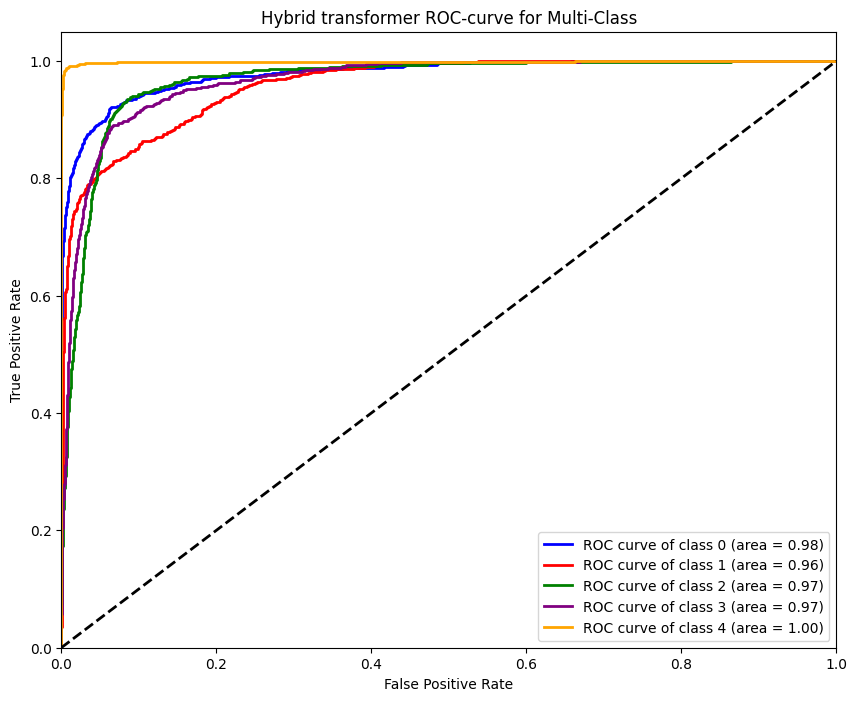

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid transformer ROC-curve for Multi-Class')
plt.legend(loc="lower right")
# plt.savefig('Results_models/Transformer /ViT_ROC_curves.png')
plt.show()

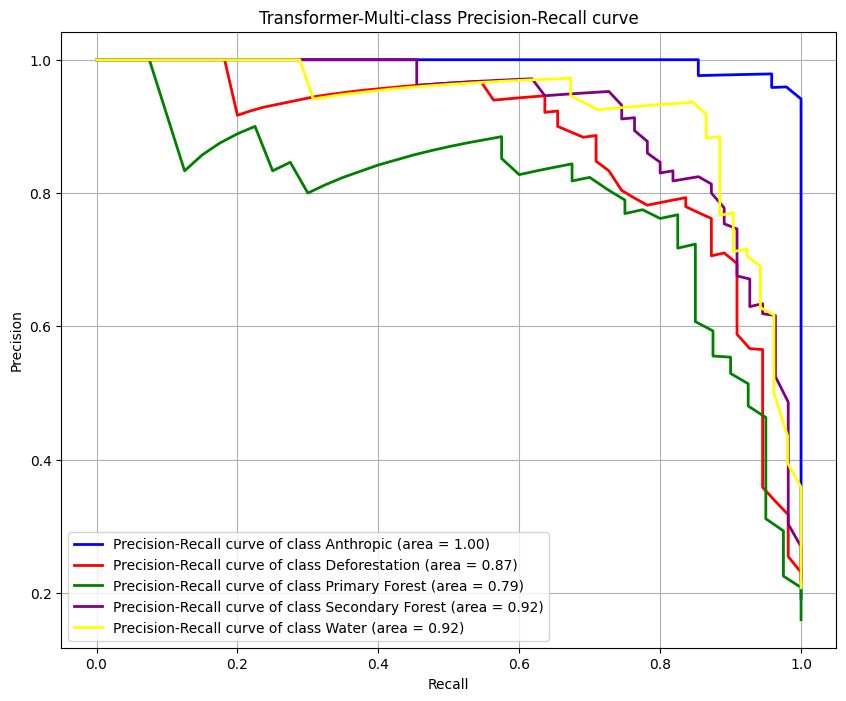

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Generate a synthetic multi-class classification dataset
X, y = make_classification(n_samples=1000, n_features=20,
                           n_classes=5, random_state=42, n_informative=3,
                           n_clusters_per_class=1)

# Define class names
class_names = ['Anthropic', 'Deforestation', 'Primary Forest', 'Secondary Forest', 'Water']

# Binarize the labels for a multi-class setup
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a model using OneVsRestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train, y_train)

# Predict probabilities
y_scores = classifier.predict_proba(X_test)

# Setup plot details
colors = ['blue', 'red', 'green', 'purple', 'yellow']
plt.figure(figsize=(10, 8))

# Compute Precision-Recall curve and area for each class
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_scores[:, i])
    average_precision = average_precision_score(y_test[:, i], y_scores[:, i])
    
    plt.plot(recall, precision, color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'.format(class_names[i], average_precision))

plt.title('Transformer-Multi-class Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('Results_models/Transformer /st_PR_curve_classes.png')
plt.show()


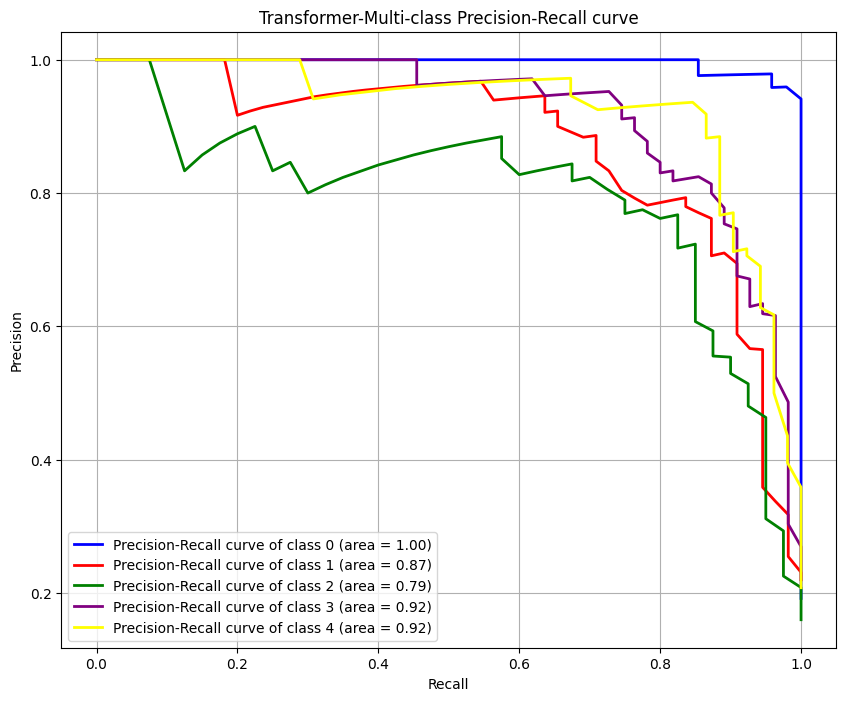

Bootstrap 95% CI for PR AUC:
Class 0: [0.9856 - 1.0000]
Class 1: [0.7785 - 0.9415]
Class 2: [0.6531 - 0.9083]
Class 3: [0.8563 - 0.9669]
Class 4: [0.8491 - 0.9766]
Cross-Validation Mean and Std for PR AUC:
Class 0: Mean PR AUC = 0.9830, Std PR AUC = 0.0128
Class 1: Mean PR AUC = 0.8429, Std PR AUC = 0.0520
Class 2: Mean PR AUC = 0.8688, Std PR AUC = 0.0517
Class 3: Mean PR AUC = 0.9190, Std PR AUC = 0.0237
Class 4: Mean PR AUC = 0.9485, Std PR AUC = 0.0217
   Class  Bootstrap Lower CI  Bootstrap Upper CI  CV Mean PR AUC  \
0      0            0.985580            1.000000        0.983048   
1      1            0.778518            0.941498        0.842900   
2      2            0.653131            0.908299        0.868821   
3      3            0.856296            0.966853        0.918996   
4      4            0.849131            0.976572        0.948482   

   CV Std PR AUC  
0       0.012764  
1       0.052014  
2       0.051668  
3       0.023701  
4       0.021660  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd

# Generate a synthetic multi-class classification dataset
X, y = make_classification(n_samples=1000, n_features=20,
                           n_classes=5, random_state=42, n_informative=3,
                           n_clusters_per_class=1)

# Binarize the labels for a multi-class setup
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a model using OneVsRestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train, y_train)

# Predict probabilities
y_scores = classifier.predict_proba(X_test)

# Setup plot details
colors = ['blue', 'red', 'green', 'purple', 'yellow']
plt.figure(figsize=(10, 8))

# Compute Precision-Recall curve and area for each class
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_scores[:, i])
    average_precision = average_precision_score(y_test[:, i], y_scores[:, i])
    
    plt.plot(recall, precision, color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision))

plt.title('Transformer-Multi-class Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('Results_models/Transformer /st_PR_curve_classes.png')
plt.show()

# Quantify uncertainties using Bootstrap
def bootstrap_pr_auc(y_test, y_scores, n_classes, n_bootstraps=1000, random_seed=42):
    rng = np.random.RandomState(random_seed)
    pr_aucs = np.zeros((n_classes, n_bootstraps))

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_scores), len(y_scores))
        for j in range(n_classes):
            if len(np.unique(y_test[indices, j])) < 2:
                continue
            precision, recall, _ = precision_recall_curve(y_test[indices, j], y_scores[indices, j])
            pr_aucs[j, i] = auc(recall, precision)

    ci_lower = np.percentile(pr_aucs, 2.5, axis=1)
    ci_upper = np.percentile(pr_aucs, 97.5, axis=1)
    return ci_lower, ci_upper

ci_lower, ci_upper = bootstrap_pr_auc(y_test, y_scores, n_classes)
print("Bootstrap 95% CI for PR AUC:")
for i in range(n_classes):
    print(f"Class {i}: [{ci_lower[i]:.4f} - {ci_upper[i]:.4f}]")

# Quantify uncertainties using Cross-Validation
def cross_val_pr_auc(model, X, y, cv=5):
    cv = StratifiedKFold(n_splits=cv)
    pr_aucs = np.zeros((n_classes, cv.n_splits))

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, np.argmax(y, axis=1))):
        model.fit(X[train_idx], y[train_idx])
        y_scores = model.predict_proba(X[test_idx])
        for j in range(n_classes):
            precision, recall, _ = precision_recall_curve(y[test_idx][:, j], y_scores[:, j])
            pr_aucs[j, fold_idx] = auc(recall, precision)

    mean_pr_auc = np.mean(pr_aucs, axis=1)
    std_pr_auc = np.std(pr_aucs, axis=1)
    return mean_pr_auc, std_pr_auc

mean_pr_auc, std_pr_auc = cross_val_pr_auc(classifier, X, y)
print("Cross-Validation Mean and Std for PR AUC:")
for i in range(n_classes):
    print(f"Class {i}: Mean PR AUC = {mean_pr_auc[i]:.4f}, Std PR AUC = {std_pr_auc[i]:.4f}")

# Create a DataFrame to store results
results = {
    'Class': range(n_classes),
    'Bootstrap Lower CI': ci_lower,
    'Bootstrap Upper CI': ci_upper,
    'CV Mean PR AUC': mean_pr_auc,
    'CV Std PR AUC': std_pr_auc
}

df_results = pd.DataFrame(results)
print(df_results)

# Save results to CSV
df_results.to_csv('Results_models/Transformer /pr_auc_uncertainties.csv', index=False)


### Model prediction on inference 

In [ ]:
import rasterio
import os
import numpy as np
from matplotlib import pyplot as plt

# Define the image directory
image_dir = './Images'

# Define the years of interest
years_of_interest = [2012, 2013,2014, 2015,2016, 2017,2018, 2019,2020, 2021]

# Generate the paths for Landsat images for the specified years
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

# Define the Landsat bands
landsat_bands = [1, 2, 3, 4, 5]  # Band indices for Landsat 5, 8, etc.

# Initialize an empty list to store the stacked images
stacked_images = []

# Process each image
for image_path in image_paths:
    with rasterio.open(image_path) as src:
        # Extract the year from the image path
        year = int(os.path.basename(image_path).split('_')[1].split('.')[0])

        # Stack the bands without normalization
        image = np.stack([src.read(band) for band in landsat_bands], axis=0)

        # Append the raw bands to the list
        stacked_images.append(image)

# Stack the images along the first axis to create a single array
stacked_images_array = np.stack(stacked_images, axis=0)

# Check the shape of the stacked images array
print("Shape of stacked images array:", stacked_images_array.shape)


Shape of stacked images array: (10, 5, 7046, 7206)


In [ ]:
# Transpose the dimensions to bring the last two dimensions together
transposed_array = np.transpose(stacked_images_array, (2, 3, 0, 1))

# Reshape the transposed array
reshaped_array = transposed_array.reshape(-1, transposed_array.shape[3], transposed_array.shape[2])

# Check the shape of the reshaped array
print("Shape of reshaped array:", reshaped_array.shape)

Shape of reshaped array: (50773476, 5, 10)


In [ ]:
from tensorflow.keras.models import load_model

# Assuming PositionEmbedding and TransformerBlock are defined or imported
model_path = 'Results_models/ViT_transfomer/ViT_model_model5.h5'
model = load_model(model_path, custom_objects={
    'PositionEmbedding': PositionEmbedding,
    'TransformerBlock': TransformerBlock
})

# model.summary()


In [ ]:
from tensorflow.keras.models import load_model

# Define the path to your model file
model_path = 'Results_models/ViT_transfomer/Transfomer_model_model10.h5'

# Load the model from the file
model = load_model(model_path, custom_objects={
    'PositionEmbedding': PositionEmbedding,
    'TransformerBlock': TransformerBlock
})

# Assuming 'reshaped_array' is your input data properly shaped for prediction
predictions = model.predict(reshaped_array, batch_size=30)
print(predictions.shape)


2024-06-25 11:19:46.700152: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.46GiB (rounded to 10154695424)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-06-25 11:19:46.700674: W tensorflow/core/common_runtime/bfc_allocator.cc:491] _______***_**********________________________________***************************************_*******


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

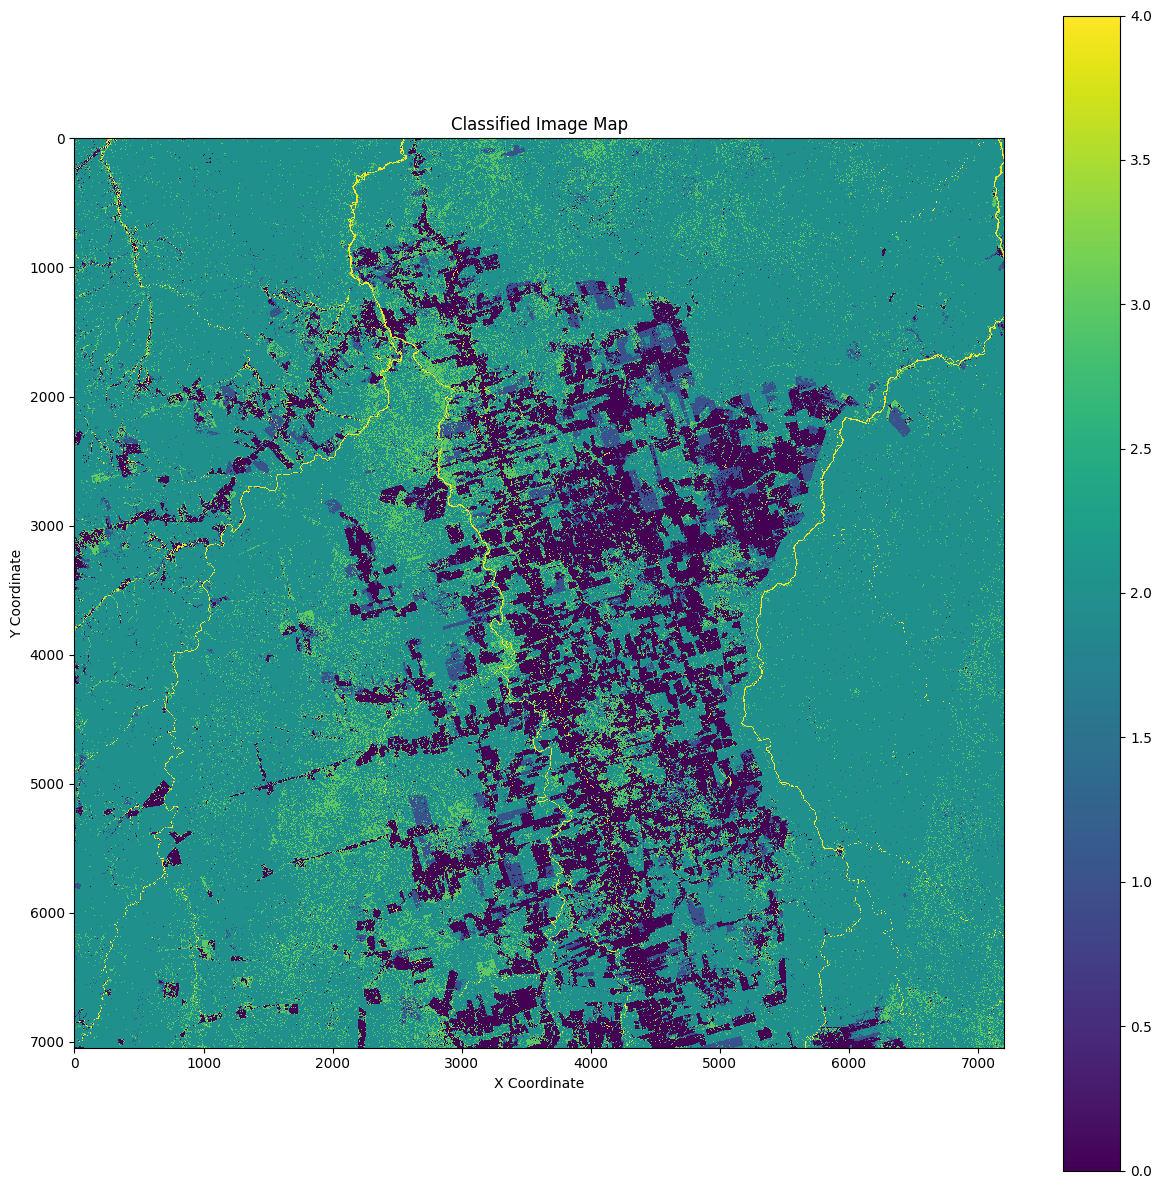

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you've already computed predicted_classes from flat_predicted
predicted_classes = np.argmax(predictions, axis=1)

# Reshape to the chosen dimensions
try:
    dimensions = (7046, 7206)  # Chosen from your provided possible dimensions
    classified_image = predicted_classes.reshape(dimensions)

    # Plot the reshaped array as an image
    plt.figure(figsize=(15, 15))  # Set figure size to something large for better visibility
    plt.imshow(classified_image, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Classified Image Map')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
except Exception as e:
    print("Error in reshaping or plotting:", str(e))


In [ ]:
  import rasterio
import os

# Define the image directory and file names
image_dir = "./Images"
image_path_2021 = os.path.join(image_dir, "Landsat_2021.tif")

# Load the image using rasterio and keep it open
with rasterio.open(image_path_2021) as src:
    # Read the image data
    image_data = src.read()
    
    # Assuming 'classified_image' is your classified map with shape (height, width)
    
    # Reshape the classified image to (height, width)
    classified_image_reshaped = classified_image.reshape(1, *classified_image.shape)
    
    # Save the prediction results
    with rasterio.open("Results_models/ViT_transfomer/Finalvit_predicted2021_5.tif", 'w', **src.profile) as dst:
        # Write the classified map to the output raster file
        dst.write(classified_image_reshaped[0], 1)
  